In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
if 'google.colab' in sys.modules:
   %pip install -q stellargraph[demos]==1.2.1

import pandas as pd 
import numpy as np
import torch
import torch.functional as F
from torch import Tensor
import matplotlib.pyplot  as plt 
import os
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline
from stellargraph import datasets

# load dataset

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


In [ ]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,726
Genetic_Algorithms,406
Probabilistic_Methods,379
Theory,344
Case_Based,285
Reinforcement_Learning,214
Rule_Learning,131


In [ ]:
from sklearn.model_selection import train_test_split
train_subjects, test_subjects = train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = train_test_split(
    test_subjects, train_size=600, test_size=None, stratify=test_subjects
)

In [ ]:
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")
train_gen = generator.flow(train_subjects.index, train_targets)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()
x_out
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 1s - loss: 1.9486 - acc: 0.1071 - val_loss: 1.9039 - val_acc: 0.3550 - 1s/epoch - 1s/step
Epoch 2/200
1/1 - 0s - loss: 1.9064 - acc: 0.2929 - val_loss: 1.8478 - val_acc: 0.3800 - 80ms/epoch - 80ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8303 - acc: 0.3429 - val_loss: 1.7799 - val_acc: 0.3700 - 82ms/epoch - 82ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7364 - acc: 0.3643 - val_loss: 1.7071 - val_acc: 0.3650 - 79ms/epoch - 79ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6600 - acc: 0.3857 - val_loss: 1.6342 - val_acc: 0.3767 - 78ms/epoch - 78ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5640 - acc: 0.4286 - val_loss: 1.5636 - val_acc: 0.3917 - 82ms/epoch - 82ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4302 - acc: 0.5286 - val_loss: 1.4941 - val_acc: 0.4517 - 79ms/epoch - 79ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3544 - acc: 0.5000 - val_loss: 1.4229 - val_acc: 0.5000 - 81ms/epoch - 81ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2306 - acc: 0.5857 - val_loss: 1.3509 - val_acc: 0.5183 - 82ms/epoch - 82ms/s

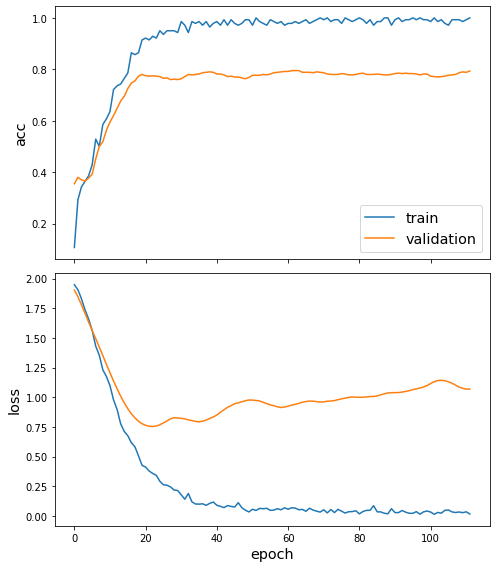

In [ ]:
sg.utils.plot_history(history)

## IDEA 2

In [ ]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
rw = BiasedRandomWalk(G)
walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=16,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

In [ ]:
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=300, window=4, min_count=0, sg=1, workers=2, iter=1)

In [ ]:
node_ids = model.wv.index2word  # list of node IDs
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]
node_emb = (model.wv.vectors) 

In [ ]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_emb)

In [ ]:
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
encoder = LabelEncoder()
X = node_emb
y = node_targets
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)


In [ ]:
#  make use of Support Vector Machine 
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
svc = SVC(C=2)
ovr = OneVsRestClassifier(svc)
ovr.fit(X_train, y_train)
y_pred = ovr.predict(X_test)


In [ ]:
acc = accuracy_score(y_test,y_pred)
print("Accuracy of Node Embeddings + SVC: ",acc)

Accuracy of Node Embeddings + SVC:  0.7616899097621


### WORD FEATURES
Please find the results in new notebook: TextFeatures

In [1]:
word_features = G.node_features()
X = word_features
X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)

svc_ = SVC(C=2)
ovr_ = OneVsRestClassifier(svc_)
ovr_.fit(X_train,y_train)
y_pred = ovr_.predict(X_test)


acc = accuracy_score(y_test,y_pred)
print("Accuracy of Node Word Features + SVC: ",acc)

### NODE EMBEDDINGS + WORD FEATURES

In [ ]:
combined = torch.cat((torch.Tensor(node_emb),torch.Tensor(word_features)),axis=1)
combined = combined.detach().numpy()

X_train, X_test, y_train, y_test = train_test_split(combined, y, train_size=0.1, test_size=None)

svc2 = SVC(C=2)
ovr2 = OneVsRestClassifier(svc2)
ovr2.fit(X_train,y_train)
y_pred = ovr2.predict(X_test)

acc = accuracy_score(y_test,y_pred)
print("Accuracy of Node Embeddings + Word features +  SVC: ",acc)

Accuracy of Node Embeddings + Word features +  SVC:  0.7362592288761279
